<a href="https://colab.research.google.com/github/naveenbreddy/Data-Science-Portfolio-Projects/blob/main/Clustering_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
! cp kaggle.json ~/.kaggle/


In [89]:
! chmod 600 ~/.kaggle/kaggle.json


In [90]:
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python


customer-segmentation-tutorial-in-python.zip: Skipping, found more recently modified local copy (use --force to force download)


In [91]:
import zipfile
!unzip customer-segmentation-tutorial-in-python.zip -d /content/

Archive:  customer-segmentation-tutorial-in-python.zip
replace /content/Mall_Customers.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from kneed import KneeLocator

import warnings                    ## Filter warnings
warnings.filterwarnings('ignore')



In [93]:
df = pd.read_csv("/content/Mall_Customers.csv")

In [94]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [95]:
df.shape

(200, 5)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [97]:
#Renaming the last two column names 
df.rename(columns = {"Annual Income (k$)": 'Annual_Income', "Spending Score (1-100)": "Spending_score" }, inplace =  True)

In [98]:
df.isnull().sum()

CustomerID        0
Gender            0
Age               0
Annual_Income     0
Spending_score    0
dtype: int64

In [99]:
df.isna().sum()

CustomerID        0
Gender            0
Age               0
Annual_Income     0
Spending_score    0
dtype: int64

No nulls and no Nas

In [100]:
df.describe()

,CustomerID,Age,Annual_Income,Spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [101]:
df.set_index('CustomerID')

,Gender,Age,Annual_Income,Spending_score
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [102]:
df.duplicated().sum()

0

No duplicates as well so the data is clean

Moving on to some visualizations

<Axes: title={'center': 'Age distribution'}, xlabel='Age', ylabel='Density'>

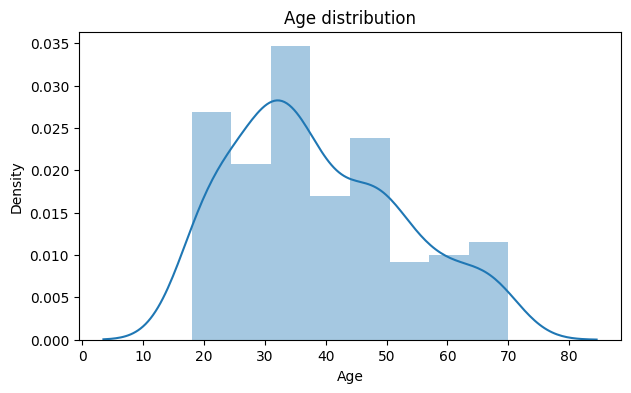

In [103]:
plt.figure(figsize = (7,4))
plt.title('Age distribution')
sns.distplot(df['Age'], kde = True )


<Axes: ylabel='Gender'>

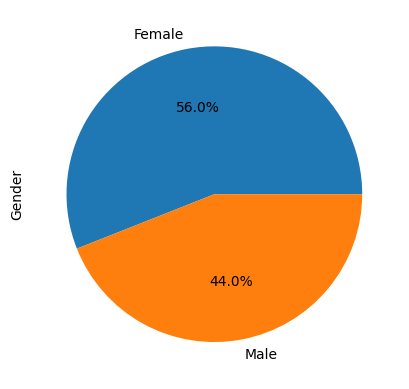

In [104]:
df['Gender'].value_counts().plot(kind = 'pie', autopct='%1.1f%%')

<Axes: xlabel='Annual_Income', ylabel='Spending_score'>

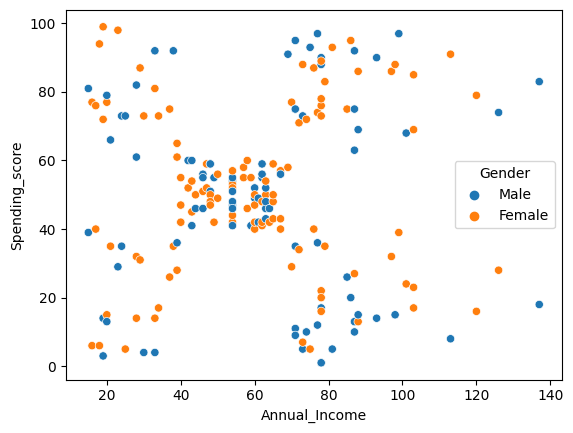

In [105]:
sns.scatterplot(x = df['Annual_Income'], y = df['Spending_score'], hue = df['Gender'])

In [106]:
num_columns = ['Age','Annual_Income', 'Spending_score']

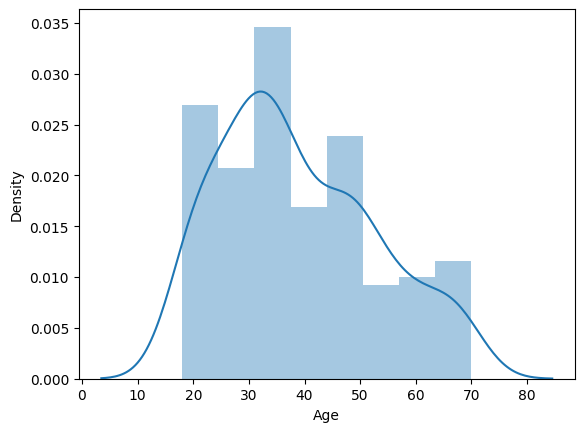

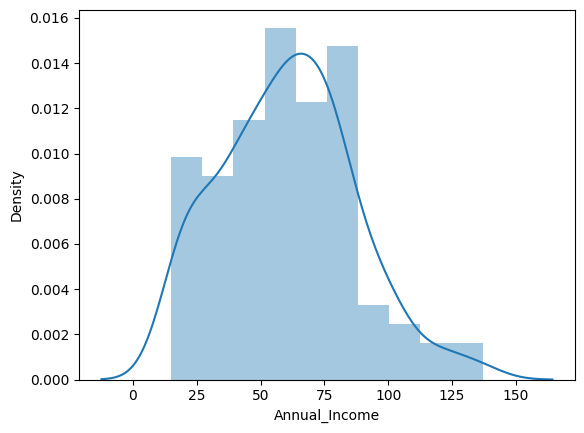

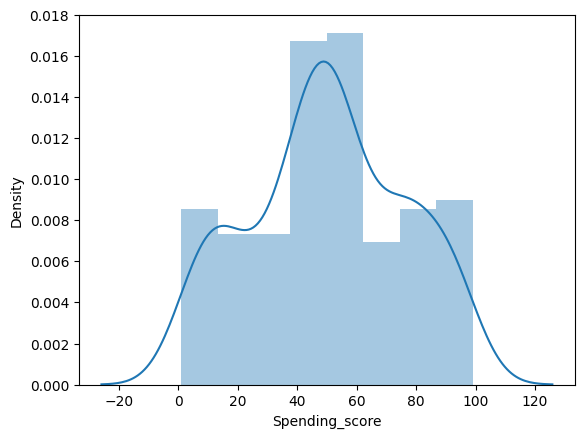

In [107]:
for i in num_columns:
  plt.figure()
  sns.distplot(df[i])

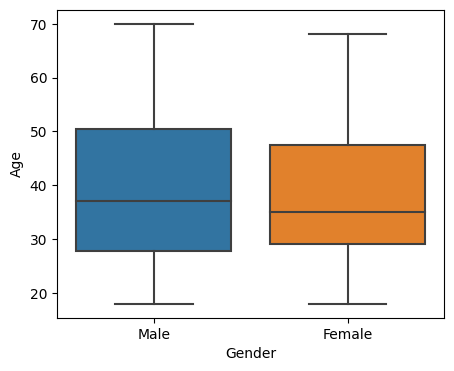

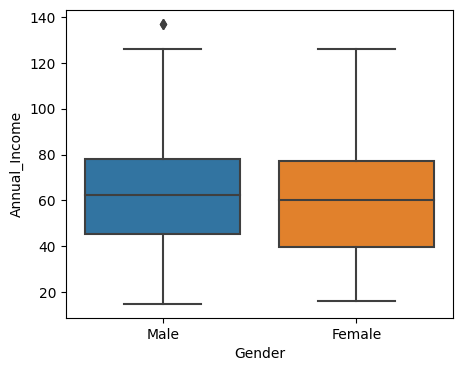

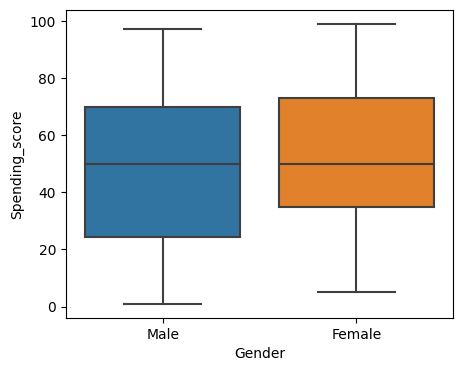

In [108]:
for i in num_columns:
  plt.figure(figsize = (5,4))
  sns.boxplot(data = df, x ='Gender', y = df[i])

In [109]:

#Acheiving a whole lotta above using a profile report
profile = ProfileReport(df)

In [111]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [112]:
df.corr()['Spending_score']

CustomerID        0.013835
Age              -0.327227
Annual_Income     0.009903
Spending_score    1.000000
Name: Spending_score, dtype: float64

<Axes: >

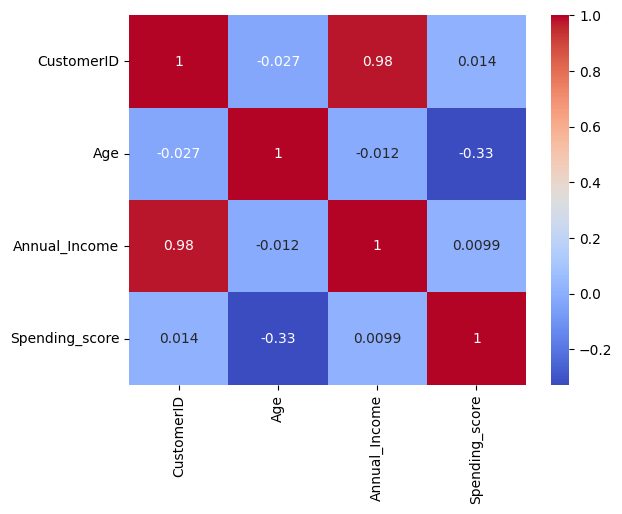

In [113]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

In [114]:
#Scaling and labeling the data
df['Gender'] = df['Gender'].map({'Male':'1','Female':'0'})


In [134]:
scaler = StandardScaler()
x = df[['Age','Annual_Income','Spending_score']]
scaled_features = scaler.fit_transform(x.values)


In [144]:
df_new = pd.DataFrame(scaled_features, index=x.index, columns=x.columns)

In [149]:
df_new = pd.concat([df['Gender'],df_new], axis =1)

In [153]:
#Using Elbow method first to get the ideal cluser numbers

wsse = []

for i in range(1,11):
  kmeans_model = KMeans(n_clusters= i, init = "k-means++")
  kmeans_model.fit(df_new)
  wsse.append(kmeans_model.inertia_)
wsse

[649.2799999999999,
 438.52241155677746,
 344.66079147574976,
 254.28290726083472,
 216.7849015165104,
 181.9514362434146,
 164.83848356816333,
 154.52025744440238,
 141.12301379874546,
 131.64530433417514]

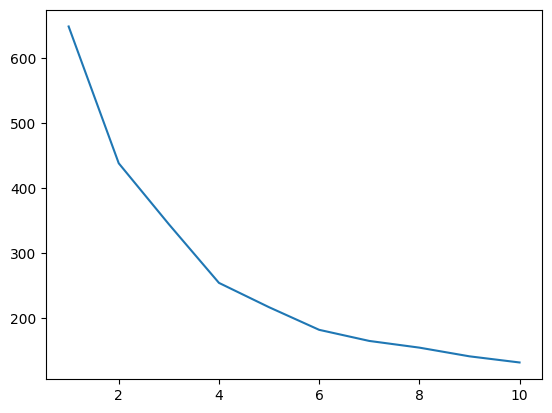

In [157]:
plt.plot(np.arange(1,11), wsse )

In [161]:
from kneed import KneeLocator

In [166]:
kl = KneeLocator(range(1,11), wsse, curve="convex", direction = 'decreasing')
kl.elbow

4

In [169]:
#Using the silhouette method to get the k value
sil_score = []

for i in range(2,11):
  kmeans_model = KMeans(n_clusters= i, init = "k-means++")
  kmeans_model.fit(df_new)
  score = silhouette_score(df_new, kmeans_model.labels_)
  sil_score.append(score)

sil_score


[0.30319765641607577,
 0.31384595454509323,
 0.35027020434653977,
 0.34977050035201074,
 0.356485834425401,
 0.3315725968911807,
 0.3356987226958421,
 0.3383014639321998,
 0.3425944608306915]

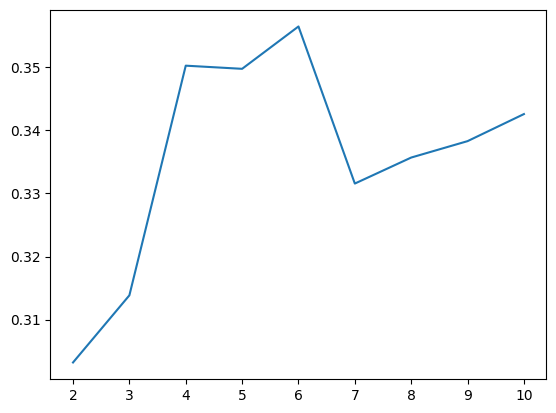

In [171]:
plt.plot(np.arange(2,11), sil_score )

identifying 4 as ideal clusters - now building model with k = 4

In [187]:
final_model = KMeans(n_clusters= 5, init = 'k-means++')
final_model.fit(df_new)

KMeans(n_clusters=5)

In [188]:
clusters = final_model.fit_predict(df_new)

In [189]:
df['clusters'] = clusters

<Axes: xlabel='Annual_Income', ylabel='Spending_score'>

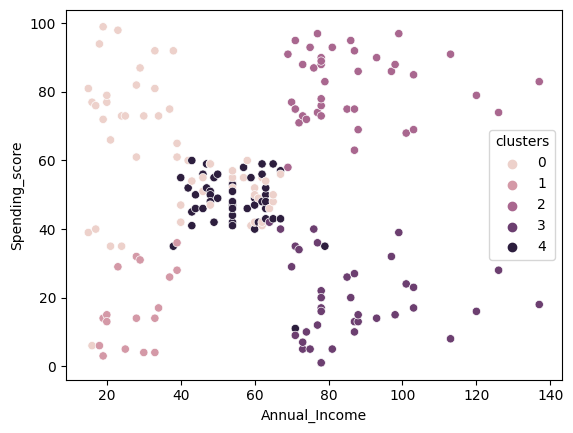

In [190]:
sns.scatterplot(data = df, x = 'Annual_Income', y ='Spending_score', hue = 'clusters')

In [191]:
import scipy.cluster.hierarchy as shc

In [202]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
df_new = scaler1.fit_transform(x)
df_new = pd.DataFrame(df_new, columns = x.columns)

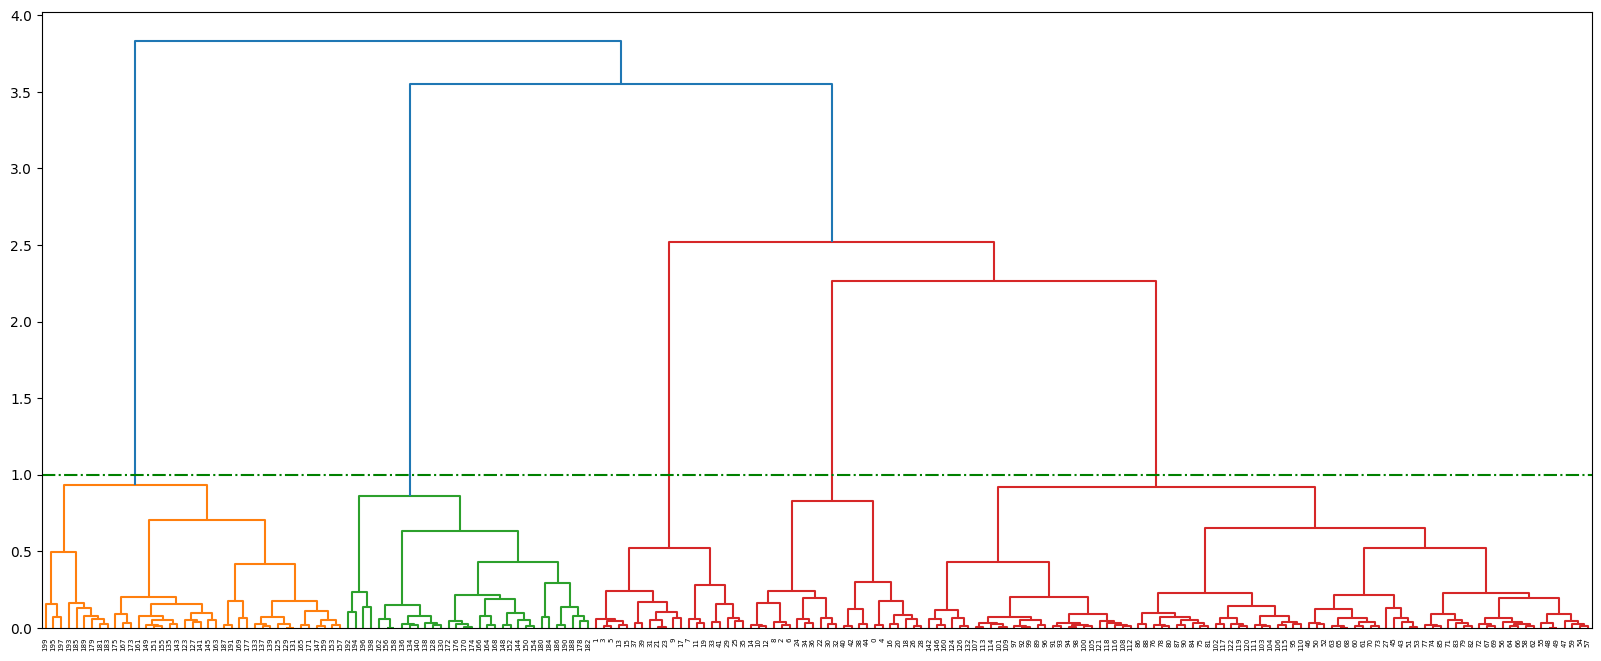

In [206]:
plt.figure(figsize = (20,8))
dendrogram = shc.dendrogram(shc.linkage(df_new, method = 'ward'))
plt.axhline(y = 1, color = 'g', linestyle = 'dashdot')

In [207]:
#sounds like k = 5 clusters is better fit

In [209]:
clusters = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_kmeans = clusters.fit_predict(df_new)

In [210]:
df_new1 = df.copy()
df_new1['clusters'] = y_kmeans

<Axes: xlabel='Annual_Income', ylabel='Spending_score'>

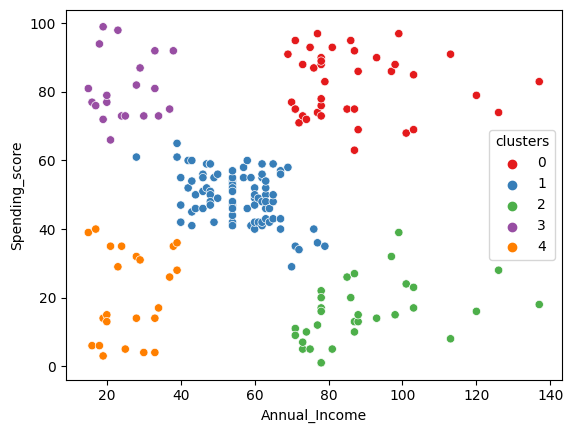

In [214]:
sns.scatterplot(data = df_new1, x = 'Annual_Income', y ='Spending_score', hue = 'clusters',palette="Set1")

In [222]:
pd.crosstab(df_new1['clusters'],df_new1['Gender'], normalize = True)

Gender,0,1
clusters,,
0,0.105,0.090
1,0.255,0.175
2,0.070,0.090
3,0.060,0.040
4,0.070,0.045


In [224]:
df.groupby(df_new1['clusters'])['Age','Annual_Income','Spending_score'].mean()

,Age,Annual_Income,Spending_score
clusters,,,
0,32.692308,86.538462,82.128205
1,42.395349,55.488372,49.267442
2,41.000000,89.406250,15.593750
3,24.850000,24.950000,81.000000
4,45.217391,26.304348,20.913043
